In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
from pandas import Series, DataFrame
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp

import datetime
plt.rc('figure', figsize=(16, 10))
from numpy.linalg import inv
from numpy import dot
import re

# FINM 8006 Assignment 2
### Due Friday 19, October, 2018

## Instructions

* You have the option of completing your assignment directly in this notebook. You should have Jupyter (conda install jupyter) installed if you want to use this. 
* You can alternatively write your answers in the editor of your choosing (Words, etc.), and run your code in Python or R in a separate file. 
* If you want to use R, I suggest you use R studio and [R Markdown](http://rmarkdown.rstudio.com)
* Some parts contains hints in code, you don't neccesary need to follow the exact hint. But please follow the naming convention as suggested. 

### Quick Jupyter notebook
* You can add or delete cell as you go
* Cells can be a [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#html) cell in which you write your texts and maths. Your math can be typed in [latex symbols](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) using `$$ math $$` in a markdown cell. 
* Default cells are code cells in which you run your python code. 
* When you are ready to run a (markdown or code) cell, press RETURN + SHIFT at the same time to run the cell.  
* Jupyter uses Ipython, so that your codes can be run cell by cell. 

## Set up and Questions

### Asset Pricing in Chinese Markets

Many have commented that the Chinese stock market is very different from the more mature markets. In this assignment, you will explore some aspects of the asset pricing in Chinese markets.

#### Loading data

You are given three data sets from year 2000: 'csmar_be.csv' has the December book value (BE) of firms (STKCD). 'csmarstk0016.csv' has monthly market value (ME) and return (ret) information of individual stocks. Data is cleaned to exclude micro stoks and penny stocks. 'csmarmktretrf.csv' has market and risk free returns. Market return here is proxied by returns on the SSE. 

In [24]:
# December Book Equity where BE >0
decbe = pd.read_csv('csmar_be.csv')
decbe.date = pd.to_datetime(decbe.date.astype('str'), format='%Y-%m-%d') 
decbe = decbe.sort_values(["STKCD", 'date', 'BE'])
decbe = decbe.groupby(['STKCD', 'date']).last().reset_index()
decbe.head(3)
#length = 27984

,STKCD,date,BE
0,1,1999-12-31,2.900831e+09
1,1,2000-12-31,4.738884e+09
2,1,2001-12-31,3.627669e+09


In [25]:
# markettype 1 Shanghai A, 4, Shengzhen A
stkret =pd.read_csv('csmarstk0016.csv')
stkret.TRDMNT = pd.to_datetime(stkret.TRDMNT.astype('str'), format='%Y-%m-%d') 
stkret = stkret.loc[stkret.ret.notnull()]
stkret = stkret.set_index('TRDMNT')
stkret.head(3)
#length = 295728

,STKCD,MARKETTYPE,ME,ret
TRDMNT,,,,
2000-01-31,1,4,2.875573e+10,0.061891
2000-02-29,1,4,2.842984e+10,-0.011333
2000-03-31,1,4,2.850743e+10,0.002729


In [4]:
#number of stocks
len(pd.unique(stkret['STKCD']))

2404

In [26]:
mktret = pd.read_csv('csmarmktretrf.csv')
mktret.TRDMNT = pd.to_datetime(mktret.TRDMNT.astype('str'), format='%Y-%m-%d') 
mktret = mktret[['TRDMNT', 'mktret', 'rf']].set_index('TRDMNT')
mktret.head(3)
#length = 194

,mktret,rf
TRDMNT,,
2000-01-31,0.123413,0.001856
2000-02-29,0.118776,0.001856
2000-03-31,0.049308,0.001856


#### Preliminaries

* Q(1) Assume power utility and relative risk aversion is 3, and constent expected market excess return, what is the optimal proportion of wealth to invest in the risky (stock) assets? (you will invest in a market portfolio). 

In [27]:
r=pd.Series.mean(mktret['mktret'])
rf=mktret['rf'].iloc[-1]
sigma=pd.Series.std(mktret['mktret'])
gamma=3

In [28]:
#according to lecture2 notes p.16
riskyshare = (r-rf)/(gamma*sigma**2)
riskyshare

0.34926295971098603

* Q(1b) Your answer above may be different from the typical answer in the U.S. market, explain what mainly drives this difference?

#### Beta sorts and Fama-Macbeth style estimations

* Q(2) For each stock, obtain the CAPM beta over the whole sample. Sort stocks into 20 portfolios according to beta estimates, then do a Fama-Macbeth style estimation test. 

In [29]:
#get the market excess return ('mktrf') and stock excess return ('rirf'), create an new index 'yearg5' for every 5 years period 
stkret['mktret']=mktret['mktret']
stkret['rf']=mktret['rf']
stkret['mktrf']=stkret['mktret']-stkret['rf']
stkret['rirf']=stkret['ret']-stkret['rf']
stkret['yearg5'] = (stkret.index.year-2000)//5+1  
stkret['nobs'] = stkret.groupby(['yearg5','STKCD'])['ret'].transform(lambda x: x.count()) 
stkret = stkret[stkret.nobs>=60]  # at leat 24 observation for a stock in the period 
stkret = stkret.drop('nobs', axis=1) 
stkret.head(3)

,STKCD,MARKETTYPE,ME,ret,mktret,rf,mktrf,rirf,yearg5
TRDMNT,,,,,,,,,
2000-01-31,1,4,2.875573e+10,0.061891,0.123413,0.001856,0.121557,0.060035,1
2000-02-29,1,4,2.842984e+10,-0.011333,0.118776,0.001856,0.116920,-0.013189,1
2000-03-31,1,4,2.850743e+10,0.002729,0.049308,0.001856,0.047452,0.000873,1


In [30]:
# OLS, output the coefficient on beta 
def ols_res(stkret, xcols,  ycol):     
    X = stkret[xcols]     
    X = sm.add_constant(X)     
    return sm.OLS(stkret[ycol], X).fit().params[1] 
# beta for each stock in the 5 year periods.  
portbeta = stkret.groupby(['yearg5', 'STKCD']).apply(ols_res, ['mktrf'], ['rirf']) 
portbeta = pd.DataFrame(portbeta, columns=['beta']) 
portbeta.head() 

beta
yearg5 STKCD          
1      1      1.042858
       2      1.099297
       4      1.309503
       5      1.456156
       6      1.236281

In [31]:
#Within every 5 year period, sort stocks according to beta, and group them into 20 portfolios of similar betas.
# assign stocks to 20 portfolios in each period 
rk = lambda x: pd.Series(pd.qcut(x,20,labels=False),index=x.index) 
portbeta['port'] = portbeta.groupby(level=['yearg5'])['beta'].apply(rk) 
portbeta.head() 

beta  port
yearg5 STKCD                
1      1      1.042858     8
       2      1.099297    10
       4      1.309503    16
       5      1.456156    18
       6      1.236281    14

In [32]:
#merge portbeta back to stkret dataframe
stkret = stkret.reset_index().merge(portbeta.reset_index(), how='inner', on=['yearg5', 'STKCD']).set_index('TRDMNT' ) 
stkret.head()

,STKCD,MARKETTYPE,ME,ret,mktret,rf,mktrf,rirf,yearg5,beta,port
TRDMNT,,,,,,,,,,,
2000-01-31,1,4,2.875573e+10,0.061891,0.123413,0.001856,0.121557,0.060035,1,1.042858,8
2000-02-29,1,4,2.842984e+10,-0.011333,0.118776,0.001856,0.116920,-0.013189,1,1.042858,8
2000-03-31,1,4,2.850743e+10,0.002729,0.049308,0.001856,0.047452,0.000873,1,1.042858,8
2000-04-30,1,4,2.956269e+10,0.037017,0.019868,0.001856,0.018012,0.035161,1,1.042858,8
2000-05-31,1,4,2.793325e+10,-0.055118,0.030103,0.001856,0.028247,-0.056974,1,1.042858,8


In [33]:
# Calculate the portfolio means 
# note, market return and yearg5 do not change  
portmeanret = stkret.groupby([stkret.index,'port'])['rirf','ret', 'mktrf','yearg5'].mean() 
portmeanret = portmeanret.reset_index() 
portmeanret.head(3) 

,TRDMNT,port,rirf,ret,mktrf,yearg5
0,2000-01-31,0,0.094299,0.096155,0.121557,1
1,2000-01-31,1,0.088641,0.090497,0.121557,1
2,2000-01-31,2,0.088603,0.090459,0.121557,1


In [34]:
#run regression get the betahat for every portfolio
portbetahut = portmeanret.groupby(['yearg5', 'port']).apply(ols_res, ['mktrf'], ['rirf']) 
portbetahut.name = 'betahat' 
portbetahut = DataFrame(portbetahut) 
portbetahut.head()  

betahat
yearg5 port          
1      0     0.574050
       1     0.734535
       2     0.808388
       3     0.868364
       4     0.916219

In [35]:
#If we calculate the average  of portfolio, we should get the same results. 
# beta follows linear rule.
portbetamean = portbeta.reset_index().groupby(['yearg5', 'port'])['beta'].mean() 
portbetamean = DataFrame(portbetamean) 
portbetamean.head() 

beta
yearg5 port          
1      0     0.574050
       1     0.734535
       2     0.808388
       3     0.868364
       4     0.916219

In [36]:
# merge portfolio beta back to portfolio mean return data 
portmeanret = portmeanret.set_index(['yearg5', 'port']).join(portbetahut).reset_index() 
portmeanret.head(3) 

,yearg5,port,TRDMNT,rirf,ret,mktrf,betahat
0,1,0,2000-01-31,0.094299,0.096155,0.121557,0.57405
1,1,0,2000-02-29,0.093428,0.095284,0.116920,0.57405
2,1,0,2000-03-31,0.087320,0.089176,0.047452,0.57405


In [37]:
 # here output both alpha and betahat coefficient 
def ols_beta(df, xcols,  ycol):     
    X = df[xcols]     
    X = sm.add_constant(X)     
    return sm.OLS(df[ycol], X).fit().params 
df2 = portmeanret.groupby(['TRDMNT']).apply(ols_beta, ['betahat'], ['rirf']) 
df2.head(3) 

,const,betahat
TRDMNT,,
2000-01-31,-0.158404,0.279387
2000-02-29,-0.149998,0.252947
2000-03-31,0.093365,0.001907


In [38]:
#Finally, T-test on estimated  and lambda
#test if constant is significantly different from 0. If 'no', support CAPM. 
from scipy.stats import ttest_1samp 
print('mean alpha:', df2.const.mean()*12) 
ttest_1samp(df2.const, 0) 

mean alpha: 0.1027081186112648


Ttest_1sampResult(statistic=1.4862351910780645, pvalue=0.13897611041081867)

In [39]:
#test if theoretical excess return is significantly different from 0. If 'yes', support CAPM. 
print('Coefficeint on beta:', df2.betahat.mean()*12) 
ttest_1samp(df2.betahat, 0) 

Coefficeint on beta: 0.058082678217495805


Ttest_1sampResult(statistic=0.6675349279529526, pvalue=0.5052901987203053)

In [23]:
#step 10: real excess return
stkret.mktrf.mean()*12 
#conclusion 

0.07167623234951317

#### Forming Portfolios

According to size and MTB.

Starting from '2000-7-31', from July to end of June of each year, categorize each stock to form a 5X5 portfolios of size and book-to-market. Size and book-to-market are defined as in Fama Frech (1993). You may want to create a 'year' variable that designate portfolio formation year.

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports.html

noted: (1) BTM is calculated using end of June market value of equity and last December book value for the year starting July to next June. 
      (2) In 5x5 portfolios, return can be calculated as equally weighted. (Strictly speaking they should be value weighted, but doesn't make much difference).

In [51]:
#add a year variable to both of my data and then extract the data we need 
decbe = pd.read_csv('csmar_be.csv')
decbe.date = pd.to_datetime(decbe.date.astype('str'), format='%Y-%m-%d') 
decbe = decbe.sort_values(["STKCD", 'date', 'BE'])
decbe = decbe.groupby(['STKCD', 'date']).last().reset_index()
decbe["year"] = decbe['date'].map(lambda x: x.year+1)
stkret =pd.read_csv('csmarstk0016.csv')
stkret.TRDMNT = pd.to_datetime(stkret.TRDMNT.astype('str'), format='%Y-%m-%d') 
stkret = stkret.loc[stkret.ret.notnull()]
stkret = stkret.set_index('TRDMNT')
stkret['year'] = stkret.index.map(lambda x: x.year)
ffdt=stkret
stkret2=stkret

In [52]:
#merge the stock data and book value data together
ffdt = ffdt.reset_index().merge(decbe.reset_index(), how='inner', on=['year','STKCD']).set_index('TRDMNT')
ffdt['B/M']=ffdt.BE/ffdt.ME
ffdt.head(3)

,STKCD,MARKETTYPE,ME,ret,year,index,date,BE,B/M
TRDMNT,,,,,,,,,
2000-01-31,1,4,2.875573e+10,0.061891,2000,0,1999-12-31,2.900831e+09,0.100878
2000-02-29,1,4,2.842984e+10,-0.011333,2000,0,1999-12-31,2.900831e+09,0.102035
2000-03-31,1,4,2.850743e+10,0.002729,2000,0,1999-12-31,2.900831e+09,0.101757


In [53]:
#get the stock id for every BM category
BMlabels=['BM1','BM2','BM3','BM4','BM5']
BMdt=ffdt[ffdt.index.month==6]
BMdict={}
for y in BMdt.index.year.unique():
    test = BMdt[BMdt.index.year==y]
    test.loc[:,'B/M category']=pd.qcut(test['B/M'],5,labels=BMlabels)
    for l in BMlabels:
        BMdict[(y,l)]=test.STKCD[test['B/M category']==l].values

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [54]:
#get the stock id for every ME category
MElabels=['ME1','ME2','ME3','ME4','ME5']
MEdt=stkret[stkret.index.month==6]
MEdict={}
for y in MEdt.index.year.unique():
    test = MEdt[MEdt.index.year==y]
    test.loc[:,'ME category']=pd.qcut(test['ME'],5,labels=MElabels)
    for l in MElabels:
        MEdict[(y,l)]=test.STKCD[test['ME category']==l].values

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [55]:
#get the stock tickers in every 5_by_5 portfolio starting from 2000
ff25port={}
for y in stkret.year.unique()[0:16]:
    for bml in BMlabels:
        for mel in MElabels:
            ff25port[(y,bml,mel)]=np.intersect1d(BMdict[(y,bml)],MEdict[(y,mel)])            

In [56]:
#assign the port names for each stock
BMlabels=['BM1','BM2','BM3','BM4','BM5']
MElabels=['ME1','ME2','ME3','ME4','ME5']
year=[]
STKCD=[]
port=[]
for y in stkret.year.unique()[0:16]:
    for b in BMlabels:
        for m in MElabels:
            for s in ff25port[(y,b,m)]:
                year.append(y)
                STKCD.append(s)
                port.append(b+m)
portname={'year':year,'STKCD':STKCD,'port':port}
portname=pd.DataFrame(data=portname).set_index(['year','STKCD'])
portname.head(3)

port
year STKCD        
2000 3      BM1ME1
     4      BM1ME1
     10     BM1ME1

In [57]:
#merge the portfolio name with the stock data
for y in stkret.year.unique()[0:16]:
    stkret['year'][(stkret.index>=datetime.datetime(y,7,31)) & (stkret.index<datetime.datetime(y+1,7,31))]=y
stkret=stkret.reset_index().set_index(['year','STKCD','TRDMNT'])
stkret = stkret.reset_index().merge(portname.reset_index(), how='inner', on=['year','STKCD']).set_index('TRDMNT')
stkret=stkret[stkret.index>=datetime.datetime(2000,7,31)]
stkret.head()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,STKCD,MARKETTYPE,ME,ret,port
TRDMNT,,,,,,
2000-07-31,2000,1,4,2.872469e+10,0.020960,BM1ME5
2000-08-31,2000,1,4,2.754529e+10,-0.041059,BM1ME5
2000-09-30,2000,1,4,2.631933e+10,-0.044507,BM1ME5
2000-10-31,2000,1,4,2.723492e+10,0.034788,BM1ME5
2000-11-30,2000,1,4,3.014079e+10,0.010403,BM1ME5


* Q(3a) Show the CAPM alpha and beta of these portfolios

In [58]:
#merge with market return and rf
stkret['mktret'] = mktret['mktret']
stkret['rf'] = mktret['rf']
stkret['exret']=stkret.ret-stkret.rf
stkret['mkexret']=stkret.mktret-stkret.rf
stkret.head(3)

,year,STKCD,MARKETTYPE,ME,ret,port,mktret,rf,exret,mkexret
TRDMNT,,,,,,,,,,
2000-07-31,2000,1,4,2.872469e+10,0.020960,BM1ME5,0.052413,0.001856,0.019104,0.050557
2000-08-31,2000,1,4,2.754529e+10,-0.041059,BM1ME5,-0.000579,0.001856,-0.042915,-0.002435
2000-09-30,2000,1,4,2.631933e+10,-0.044507,BM1ME5,-0.053758,0.001856,-0.046363,-0.055614


In [62]:
#assume equal weighted then get the excess return for each portfolio at the end of every month
portexret={}
for port in stkret.port.unique():
    portexret[port]=list(stkret[stkret.port==port].groupby(['TRDMNT'])['exret'].mean())
portexret=pd.DataFrame(portexret)
portexret.index=mktret.index[mktret.index>=datetime.datetime(2000,7,31)]
portexret['mkexret']=stkret.groupby('TRDMNT')['mkexret'].mean()
portexret.head(3)

,BM1ME5,BM3ME5,BM2ME5,BM5ME5,BM4ME5,BM1ME1,BM3ME1,BM3ME4,BM4ME4,BM2ME4,...,BM5ME2,BM1ME3,BM1ME4,BM4ME3,BM4ME2,BM4ME1,BM5ME1,BM3ME3,BM3ME2,mkexret
TRDMNT,,,,,,,,,,,,,,,,,,,,,
2000-07-31,0.020503,0.014206,0.020259,0.068048,0.042592,0.094227,0.089082,0.029606,0.051353,0.034288,...,0.096738,0.033538,-0.006736,0.024396,0.049306,0.067891,0.102070,0.013125,0.055047,0.050557
2000-08-31,0.003487,-0.001824,-0.045348,-0.035930,-0.005982,0.019105,0.074348,-0.008248,-0.008640,-0.026347,...,0.017209,-0.008683,-0.004326,-0.002717,-0.002893,0.040122,0.045046,0.004558,0.002841,-0.002435
2000-09-30,-0.049325,-0.054451,-0.064596,-0.084463,-0.060620,-0.000691,0.004288,-0.049834,-0.068664,-0.041754,...,-0.048476,-0.042833,-0.023022,-0.058111,-0.044421,-0.024706,-0.048461,-0.026742,-0.024920,-0.055614


In [63]:
#get the CAPM alpha and beta and adjusted R square out
def ols_capm(Y, xcols=portexret['mkexret']):     
    X = sm.add_constant(xcols)     
    fit = sm.OLS(Y, X).fit()     
    return fit.params[0], fit.params[1], fit.rsquared_adj #, fit.mse_total, fit.mse_resid 
capm_out = portexret.apply(ols_capm) 
alpha = capm_out.apply(lambda x: x[0])[:-1].sort_index()
beta = capm_out.apply(lambda x: x[1]) [:-1].sort_index()
adjr2 = capm_out.apply(lambda x: x[2])[:-1].sort_index()

In [64]:
#define a result matrix to use furthur
def results_matrix(dfvar):     
        # get index     
        szindex = np.array(['LoBM', 'BM2', 'BM3', 'BM4', 'HiBM' ])      
        bmindex = np.array(['SMALL','ME2',"ME3",'ME4','Big'])       
        results5by5 = pd.DataFrame(dfvar.values.reshape(5,5), index=szindex, columns=bmindex) 
        return results5by5.T

In [65]:
#show CAPM alpha
print('CAPM alpha:') 
results_matrix(alpha)

CAPM alpha:


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.017097,0.017578,0.017218,0.016443,0.017615
ME2,0.006994,0.010893,0.010952,0.010798,0.011382
ME3,0.004637,0.004509,0.008241,0.007126,0.008790
ME4,0.003290,0.003222,0.005426,0.007090,0.007545
Big,-0.001937,0.001468,0.001802,0.002953,0.004984


In [66]:
#show CAPM beta
print('Portfolio Beta:') 
results_matrix(beta)

Portfolio Beta:


,LoBM,BM2,BM3,BM4,HiBM
SMALL,1.003959,1.002338,1.029844,1.018099,1.055057
ME2,1.008764,1.036024,1.034636,1.047495,1.053747
ME3,0.984721,0.995544,1.007384,1.037155,1.095631
ME4,0.961857,0.984494,1.041763,1.075100,1.086805
Big,0.969987,1.049784,1.080415,1.089740,1.053546


In [67]:
print('CAPM regression Adj R-squared') 
results_matrix(adjr2) 

CAPM regression Adj R-squared


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.527555,0.538557,0.561103,0.588532,0.612863
ME2,0.579796,0.597066,0.600389,0.632240,0.652503
ME3,0.566655,0.613204,0.638644,0.657208,0.727142
ME4,0.616237,0.659661,0.704081,0.725860,0.749847
Big,0.711819,0.804323,0.834951,0.866577,0.844605


* Q(3b) Calculate mean portfolio return and compare them with the CAPM estimates, explain any patterns in the data. 

In [103]:
meanret = portexret.iloc[:, :-1].mean().sort_index()
print('Mean Portfolio Excess Return:') 
results_matrix(meanret) 

Mean Portfolio Excess Return:


,LoBM,BM2,BM3,BM4,HiBM
SMALL,2.161408,2.208736,2.185173,2.102381,2.236234
ME2,1.153221,1.555431,1.560710,1.551092,1.612277
ME3,0.906738,0.898769,1.277353,1.179193,1.371922
ME4,0.761733,0.765186,1.011284,1.192683,1.243492
Big,0.242695,0.619114,0.666291,0.785617,0.972450


In [102]:
rf=mktret.rf.mean()
print('Mean Portfolio Return:') 
results_matrix(meanret+rf)

Mean Portfolio Return:


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.023736,0.024209,0.023973,0.023145,0.024484
ME2,0.013654,0.017676,0.017729,0.017632,0.018244
ME3,0.011189,0.011109,0.014895,0.013913,0.015841
ME4,0.009739,0.009773,0.012234,0.014048,0.014556
Big,0.004548,0.008313,0.008784,0.009978,0.011846


In [99]:
r=mktret.mktret.mean()
rf=mktret.rf.mean()
capm_estimates=beta*(r-rf)#remember to drop constants, otherwise it'll show linearity
print('CAPM predicted return:')
results_matrix(capm_estimates)

CAPM predicted return:


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.006181,0.006171,0.006340,0.006268,0.006496
ME2,0.006211,0.006378,0.006370,0.006449,0.006487
ME3,0.006063,0.006129,0.006202,0.006385,0.006745
ME4,0.005922,0.006061,0.006414,0.006619,0.006691
Big,0.005972,0.006463,0.006652,0.006709,0.006486


* Q(3c) Plot the mean excess return against CAPM predicted return, plot both within size (BM) plots and the within BM (size) plots.

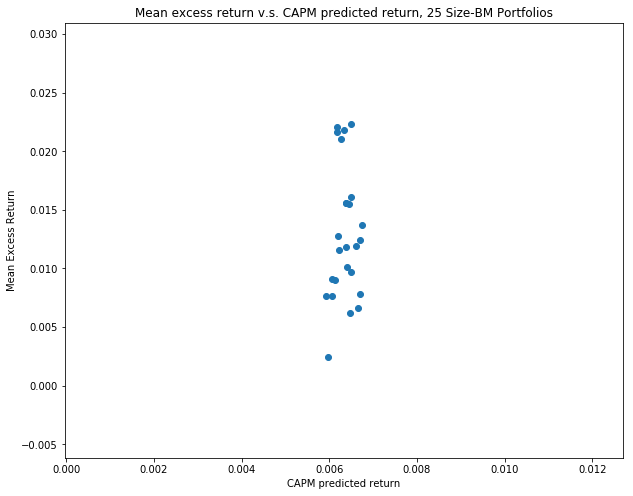

In [160]:
#Plot the mean excess return against CAPM predicted return
plt.rc('figure', figsize=(10, 8)) 
fig, ax = plt.subplots() 
plt.scatter(capm_estimates, meanret) 
plt.title('Mean excess return v.s. CAPM predicted return, 25 Size-BM Portfolios') 
plt.xlabel('CAPM predicted return') 
plt.ylabel('Mean Excess Return') 
plt.show() 

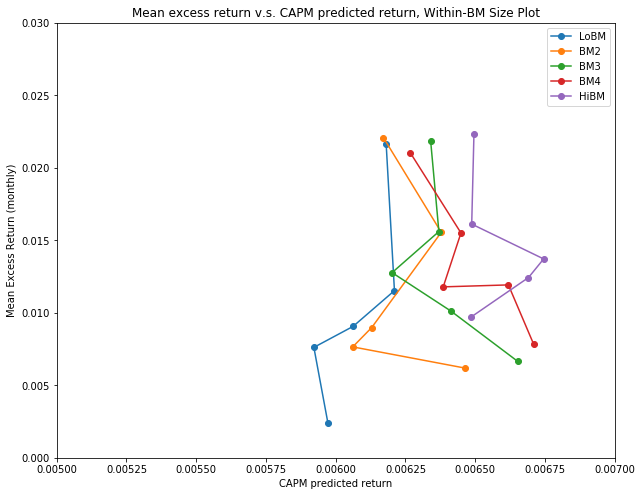

In [109]:
plt.rc('figure', figsize=(10, 8)) 
fig, ax = plt.subplots() 
for ptfl in results_matrix(meanret).columns:     
    plt.plot(results_matrix(capm_estimates)[ptfl], results_matrix(meanret)[ptfl], '-o', label=ptfl) 
plt.title('Mean excess return v.s. CAPM predicted return, Within-BM Size Plot') 
plt.xlabel('CAPM predicted return') 
plt.ylabel('Mean Excess Return (monthly)') 
plt.xlim([0.005, 0.007]) 
plt.ylim([0, 0.03]) 
plt.legend() 
plt.show()

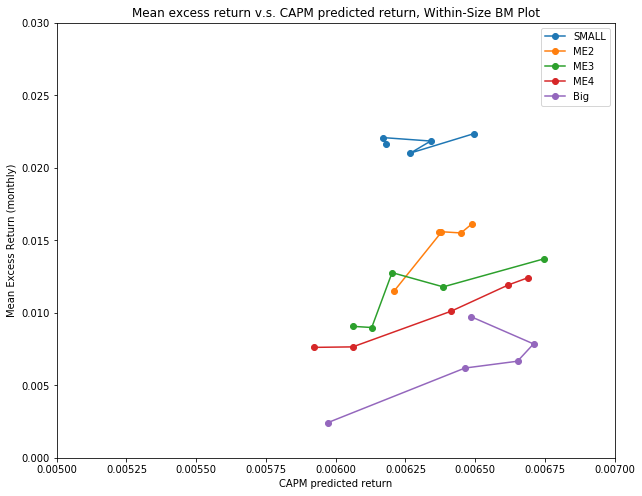

In [158]:
plt.rc('figure', figsize=(10, 8)) 
fig, ax = plt.subplots() 
for ptfl in results_matrix(meanret).T.columns:     
    plt.plot(results_matrix(capm_estimates).T[ptfl], results_matrix(meanret).T[ptfl], '-o', label=ptfl) 
plt.title('Mean excess return v.s. CAPM predicted return, Within-Size BM Plot') 
plt.xlabel('CAPM predicted return') 
plt.ylabel('Mean Excess Return (monthly)') 
plt.xlim([0.005, 0.007]) 
plt.ylim([0, 0.03]) 
plt.legend() 
plt.show()

#### Constructing SMB and HML factors

Construct 2x3 portfolios of size and BTM according to the Shanghai Stock Exchange cutoff (MARKETTYPE==1). Calculate the value-weighted returns of the portfolios and then construct SMB and HML factors following Fama French (93) procedure. 

In [113]:
ffdt2=ffdt[ffdt.MARKETTYPE==1]

In [114]:
BMlabels2=['Low','Medium','High']
BMdt=ffdt2[ffdt2.index.month==6]
BMdict={}
for y in BMdt.index.year.unique():
    test = BMdt[BMdt.index.year==y]
    test.loc[:,'B/M category']=pd.qcut(test['B/M'],[0,.3,.7,1],labels=BMlabels2)
    for l in BMlabels2:
        BMdict[(y,l)]=test.STKCD[test['B/M category']==l].values

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [115]:
Sizelabels=['Small','Big']
MEdt=ffdt2[ffdt2.index.month==6]
MEdict={}
for y in MEdt.index.year.unique():
    test = MEdt[MEdt.index.year==y]
    test.loc[:,'ME category']=pd.qcut(test['ME'],2,labels=Sizelabels)
    for l in Sizelabels:
        MEdict[(y,l)]=test.STKCD[test['ME category']==l].values

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [116]:
#get the stock tickers in every portfolio starting from 2000
ff2by3port={}
for y in stkret2.year.unique()[0:16]:
    for bml in BMlabels2:
        for sizel in Sizelabels:
            ff2by3port[(y,bml,sizel)]=np.intersect1d(BMdict[(y,bml)],MEdict[(y,sizel)])
year=[]
STKCD=[]
port=[]
for y in stkret2.year.unique()[0:16]:
    for b in BMlabels2:
        for m in Sizelabels:
            for s in ff2by3port[(y,b,m)]:
                year.append(y)
                STKCD.append(s)
                port.append(b+m)
portname={'year':year,'STKCD':STKCD,'port':port}
portname=pd.DataFrame(data=portname).set_index(['year','STKCD'])
portname.head(3)

port
year STKCD           
2000 600056  LowSmall
     600067  LowSmall
     600081  LowSmall

In [117]:
for y in stkret2.year.unique()[0:16]:
    stkret2['year'][(stkret2.index>=datetime.datetime(y,7,31)) & (stkret2.index<datetime.datetime(y+1,7,31))]=y
stkret2=stkret2.reset_index().set_index(['year','STKCD','TRDMNT'])
stkret2 = stkret2.reset_index().merge(portname.reset_index(), how='inner', on=['year','STKCD']).set_index('TRDMNT')
#stkret2=stkret2[stkret2.index>=datetime.datetime(2000,6,30)]

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
stkret2.head(3)

,year,STKCD,MARKETTYPE,ME,ret,port
TRDMNT,,,,,,
2000-01-31,2000,600000,1,6.034640e+10,0.011717,LowBig
2000-02-29,2000,600000,1,6.065970e+10,0.005192,LowBig
2000-03-31,2000,600000,1,6.078020e+10,0.001986,LowBig


In [119]:
#assume value weighted and get the excess return for each portfolio at the end of every month
portexret2={}
for port in stkret2.port.unique():
    portexret2[port]=list(stkret2[stkret2.port==port].groupby(['TRDMNT'])['ME'].sum().pct_change(1))
portexret2=pd.DataFrame(portexret2)
portexret2.index=mktret.index[mktret.index>=datetime.datetime(2000,1,31)]
portexret2=portexret2[portexret2.index>=datetime.datetime(2000,7,31)]

In [120]:
portexret2['SMB']=(portexret2.HighSmall+portexret2.MediumSmall+portexret2.LowSmall)/3-(portexret2.LowBig+portexret2.MediumBig+portexret2.HighBig)/3
portexret2['HML']=(portexret2.HighSmall+portexret2.HighBig)/2-(portexret2.LowBig-portexret2.LowSmall)/2
portexret2.head()

,LowBig,MediumBig,HighBig,HighSmall,MediumSmall,LowSmall,SMB,HML
TRDMNT,,,,,,,,
2000-07-31,0.027184,0.044188,0.081579,0.082084,0.039107,0.054805,0.007682,0.095643
2000-08-31,-0.014217,-0.012030,-0.024538,0.018372,0.039286,0.043697,0.050714,0.025874
2000-09-30,-0.053741,-0.059937,-0.070465,-0.055366,-0.017341,-0.019963,0.030491,-0.046027
2000-10-31,-0.000421,0.021937,0.029372,0.079770,0.041293,0.036449,0.035541,0.073006
2000-11-30,0.044324,0.058584,0.065707,0.065076,0.076103,0.065448,0.012670,0.075953


In [121]:
ff=portexret.merge(portexret2,how='inner',on=['TRDMNT'])

* Q(4a) Joinning factors with 25 portfolio returns, run FF 3 factor model. Does the coefficients estimates make sense? 

In [122]:
 def ols_3f(Y, xcols=ff[['mkexret', 'SMB', 'HML']]):     
        X = sm.add_constant(xcols)     
        fit = sm.OLS(Y, X).fit()     
        return fit.params, fit.rsquared_adj #, fit.mse_total, fit.mse_resid 

In [128]:
ff3m = ff.apply(ols_3f)   # x[0] coefficients and x[1] rsquares 
f3alpha = ff3m.apply(lambda x: x[0][0])[0:25].sort_index()
f3beta = ff3m.apply(lambda x: x[0][1])[0:25].sort_index()
f3smb = ff3m.apply(lambda x: x[0][2])[0:25].sort_index() 
f3hml = ff3m.apply(lambda x: x[0][3])[0:25].sort_index() 
ff3r2 = ff3m.apply(lambda x: x[1])[0:25].sort_index() 
f3beta = results_matrix(f3beta) 
f3smb = results_matrix(f3smb) 
f3hml = results_matrix(f3hml) 

In [129]:
print('FF 3 factor model factor loadings') 
pd.concat([f3beta, f3smb, f3hml], axis=1, keys=['beta', 'smb', 'hml']) 

FF 3 factor model factor loadings


beta                                               smb            \
           LoBM       BM2       BM3       BM4      HiBM      LoBM       BM2   
SMALL  0.683165  0.702764  0.736685  0.711208  0.752922  0.201218  0.201208   
ME2    0.762924  0.754492  0.749223  0.757965  0.740128  0.212664  0.203109   
ME3    0.734624  0.770697  0.752037  0.767769  0.791808  0.199017  0.189903   
ME4    0.842005  0.841392  0.849093  0.816653  0.825977  0.190766  0.150886   
Big    0.902489  0.974184  0.949819  0.955804  0.872100  0.088577  0.075953   

                                          hml                                \
            BM3       BM4      HiBM      LoBM       BM2       BM3       BM4   
SMALL  0.192619  0.169922  0.153588  0.277106  0.259258  0.253551  0.264282   
ME2    0.177801  0.155572  0.154286  0.214471  0.244149  0.246500  0.249161   
ME3    0.147413  0.156738  0.105090  0.217559  0.195991  0.220112  0.232258   
ME4    0.141553  0.118876  0.117416  0.107705  0.125821  0.167179  0.221689   
Big    0.062612  0.063509  0.018495  0.059976  0.066335  0.112114  0.114956   

                 
           HiBM  
SMALL  0.259691  
ME2    0.269376  
ME3    0.259359  
ME4    0.223639  
Big    0.153293

In [130]:
print('FF 3 factor model factor alpha') 
results_matrix(f3alpha)

FF 3 factor model factor alpha


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.014291,0.015058,0.014720,0.013589,0.014701
ME2,0.005285,0.008631,0.008447,0.008069,0.008318
ME3,0.002768,0.002911,0.005911,0.004677,0.005487
ME4,0.003115,0.002433,0.003897,0.004503,0.004915
Big,-0.002178,0.001022,0.000514,0.001627,0.002677


In [131]:
print('Adj R-Squared with Fama-Frend 3 Factor Model') 
results_matrix(ff3r2) 

Adj R-Squared with Fama-Frend 3 Factor Model


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.664632,0.668062,0.681043,0.712178,0.722080
ME2,0.698083,0.723998,0.715857,0.741441,0.776330
ME3,0.681619,0.717761,0.736039,0.763588,0.826336
ME4,0.686780,0.718195,0.773716,0.811624,0.837322
Big,0.729093,0.819751,0.859605,0.893307,0.877566


In [132]:
 # 3 coefficients for each of the 25 portfolios 
coeff = ff3m.apply(lambda x: x[0])[0:25].drop('const', axis=1).sort_index()
coeff

,mkexret,SMB,HML
BM1ME1,0.683165,0.201218,0.277106
BM1ME2,0.762924,0.212664,0.214471
BM1ME3,0.734624,0.199017,0.217559
BM1ME4,0.842005,0.190766,0.107705
BM1ME5,0.902489,0.088577,0.059976
BM2ME1,0.702764,0.201208,0.259258
BM2ME2,0.754492,0.203109,0.244149
BM2ME3,0.770697,0.189903,0.195991
BM2ME4,0.841392,0.150886,0.125821
BM2ME5,0.974184,0.075953,0.066335


* Q(4b) plot the Mean portfolio return against the Fama-French 3 factor predicted return again for both Within-BM Size Plot and Within-Size BM Plot. 

In [138]:
ff3f = ff[['mkexret','SMB','HML']] 
predictmean = coeff.dot(ff3f.mean())+rf
print('Model predicted mean return') 
results_matrix(predictmean) 

Model predicted mean return


,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.009444,0.009151,0.009253,0.009557,0.009782
ME2,0.008369,0.009045,0.009282,0.009563,0.009926
ME3,0.008421,0.008198,0.008984,0.009236,0.010354
ME4,0.006624,0.007341,0.008337,0.009546,0.009641
Big,0.006727,0.007290,0.008271,0.008351,0.009169


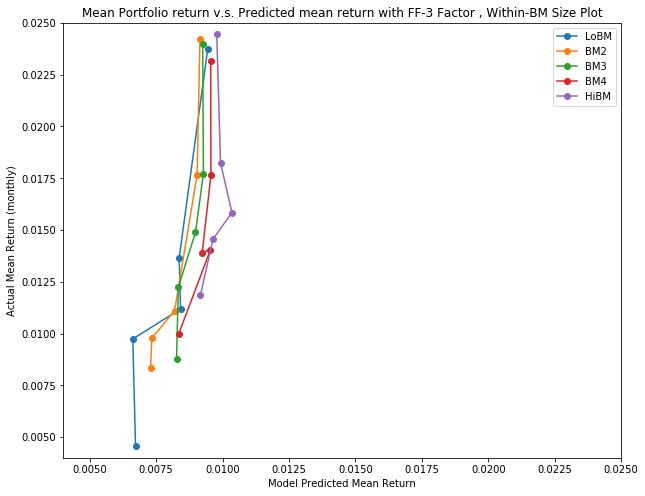

In [149]:
plt.rc('figure', figsize=(10, 8)) 
fig, ax = plt.subplots() 
for ptfl in results_matrix(meanret).columns:     
    plt.plot(results_matrix(predictmean)[ptfl], results_matrix(meanret+rf)[ptfl], '-o', label=ptfl) 
plt.title('Mean Portfolio return v.s. Predicted mean return with FF-3 Factor , Within-BM Size Plot') 
plt.xlabel('Model Predicted Mean Return') 
plt.ylabel('Actual Mean Return (monthly)') 
plt.xlim([0.004, 0.025]) 
plt.ylim([0.004, 0.025]) 
plt.legend() 
plt.show()

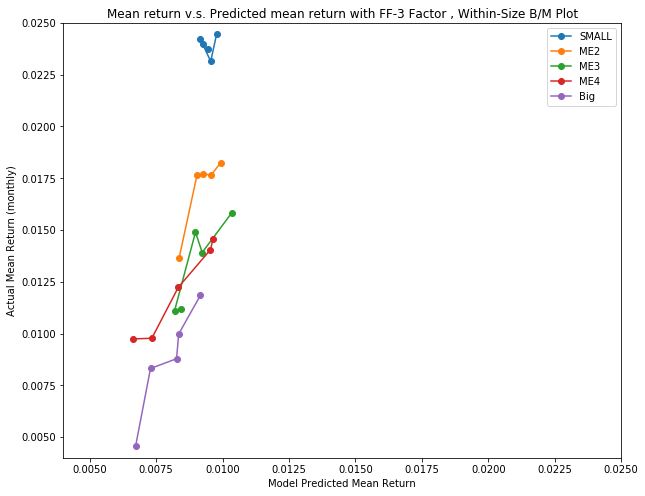

In [150]:
plt.rc('figure', figsize=(10, 8)) 
fig, ax = plt.subplots() 
for ptfl in results_matrix(meanret).T.columns:     
    plt.plot(results_matrix(predictmean).T[ptfl], results_matrix(meanret+rf).T[ptfl], '-o', label=ptfl) 
plt.title('Mean return v.s. Predicted mean return with FF-3 Factor , Within-Size B/M Plot') 
plt.xlabel('Model Predicted Mean Return') 
plt.ylabel('Actual Mean Return (monthly)') 
plt.xlim([0.004, 0.025]) 
plt.ylim([0.004, 0.025]) 
plt.legend() 
plt.show()

* Q(4c) How do the graphs compare to the earlier CAPM plots? In the U.S. data, the most severe violation of CAPM happens along BTM portfolios, What about China? Can you explain why this factor comes up so significant in the Chinese markets?

#### Momentum

* Q5 If you form a hedging porfolio of buying the top decile winners and shorting the bottom decile losers according to the last 11 month returns, how does your porfolio perform? Plot the hedging portfolio returns in the future 1 to 6 months. 

In [25]:
stkret =pd.read_csv('csmarstk0016.csv')
stkret.TRDMNT = pd.to_datetime(stkret.TRDMNT.astype('str'), format='%Y-%m-%d') 
stkret = stkret.loc[stkret.ret.notnull()]
#stkret = stkret.set_index('TRDMNT')

In [27]:
k = 12 # portfolio formation period 
j = 6 # investment period 

In [28]:
_tmp_crsp=stkret.set_index('TRDMNT')[['STKCD','ret']]

In [31]:
# calculative cumulative returns for t-k+1 to t 
umd = _tmp_crsp.groupby('STKCD')['ret'].rolling(window = k).apply(lambda x: np.prod(1+x)-1,raw=True) 
umd = umd.reset_index() 
umd.columns = ['STKCD', 'form_date', 'cumuret'] 
umd.head(15) 

,STKCD,form_date,cumuret
0,1,2000-01-31,NaN
1,1,2000-02-29,NaN
2,1,2000-03-31,NaN
3,1,2000-04-30,NaN
4,1,2000-05-31,NaN
5,1,2000-06-30,NaN
6,1,2000-07-31,NaN
7,1,2000-08-31,NaN
8,1,2000-09-30,NaN
9,1,2000-10-31,NaN


In [32]:
 # for each portfolio formation date, rank stock into decile according to cumuret 
umd=umd.dropna(axis=0, subset=['cumuret']) 
dec_assignment = lambda x: pd.qcut(x, 10,labels=['dec'+str(i) for i in range(1,11)],) 
umd['momr']=umd.groupby('form_date')['cumuret'].transform(dec_assignment) 
umd['hdate1']=umd['form_date']+MonthEnd(1) 
umd['hdate2']=umd['form_date']+MonthEnd(j) 
umd.head() 

,STKCD,form_date,cumuret,momr,hdate1,hdate2
11,1,2000-12-31,-0.047442,dec1,2001-01-31,2001-06-30
12,1,2001-01-31,-0.074542,dec1,2001-02-28,2001-07-31
13,1,2001-02-28,-0.119548,dec2,2001-03-31,2001-08-31
14,1,2001-03-31,0.010792,dec3,2001-04-30,2001-09-30
15,1,2001-04-30,-0.066753,dec2,2001-05-31,2001-10-31


In [34]:
# merge decile assignment with original trading data 
# keep only valid assignment when trade date is in the range of future j months 
port = stkret[['STKCD','TRDMNT','ret']].merge(umd, on=['STKCD'], how='inner') 
port = port[(port['hdate1']<=port['TRDMNT']) & (port['TRDMNT']<=port['hdate2'])] 
port.head() 

,STKCD,TRDMNT,ret,form_date,cumuret,momr,hdate1,hdate2
2172,1,2001-01-31,0.031680,2000-12-31,-0.047442,dec1,2001-01-31,2001-06-30
2353,1,2001-02-28,-0.059413,2000-12-31,-0.047442,dec1,2001-01-31,2001-06-30
2354,1,2001-02-28,-0.059413,2001-01-31,-0.074542,dec1,2001-02-28,2001-07-31
2534,1,2001-03-31,0.151171,2000-12-31,-0.047442,dec1,2001-01-31,2001-06-30
2535,1,2001-03-31,0.151171,2001-01-31,-0.074542,dec1,2001-02-28,2001-07-31


In [48]:
# equaly weighted return for each date, dec, and formation 
port=port.groupby(['TRDMNT','momr','form_date'])['ret'].mean().reset_index()
port.head(10) 

,TRDMNT,momr,form_date,ret
0,2001-01-31,dec1,2000-12-31,-0.011825
1,2001-01-31,dec2,2000-12-31,0.003521
2,2001-01-31,dec3,2000-12-31,0.003484
3,2001-01-31,dec4,2000-12-31,-0.001137
4,2001-01-31,dec5,2000-12-31,-0.006119
5,2001-01-31,dec6,2000-12-31,0.000499
6,2001-01-31,dec7,2000-12-31,-0.022240
7,2001-01-31,dec8,2000-12-31,-0.018430
8,2001-01-31,dec9,2000-12-31,-0.018227
9,2001-01-31,dec10,2000-12-31,-0.033106


In [77]:
ewmomret = port.groupby(['TRDMNT','momr'])['ret'].mean().reset_index() 
ewmomret.groupby('momr')['ret'].describe()[['count','mean', 'std']] 

,count,mean,std
momr,,,
dec1,182.0,0.014102,0.110516
dec2,182.0,0.015973,0.106264
dec3,182.0,0.015713,0.105955
dec4,182.0,0.015950,0.104468
dec5,182.0,0.015602,0.104022
dec6,182.0,0.015486,0.103469
dec7,182.0,0.014532,0.102973
dec8,182.0,0.013420,0.101521
dec9,182.0,0.012694,0.100035


In [94]:
date=[]
losers=[]
winners=[]
for time in ewmomret.TRDMNT.unique():
    date.append(time)
    losers.append(float(ewmomret.ret[(ewmomret.TRDMNT==time) & (ewmomret.momr=='dec1')].values))
    winners.append(float(ewmomret.ret[(ewmomret.TRDMNT==time) & (ewmomret.momr=='dec10')].values))
ewmomret2=pd.DataFrame(data={'date':date,'losers':losers,'winners':winners}).set_index('date')
ewmomret2['long_short']=ewmomret2.winners-ewmomret2.losers
ewmomret2.head()

,losers,winners,long_short
date,,,
2001-01-31,-0.011825,-0.033106,-0.021281
2001-02-28,-0.076539,-0.043641,0.032898
2001-03-31,0.074343,0.077321,0.002978
2001-04-30,-0.008481,0.016615,0.025095
2001-05-31,0.032054,0.044707,0.012653


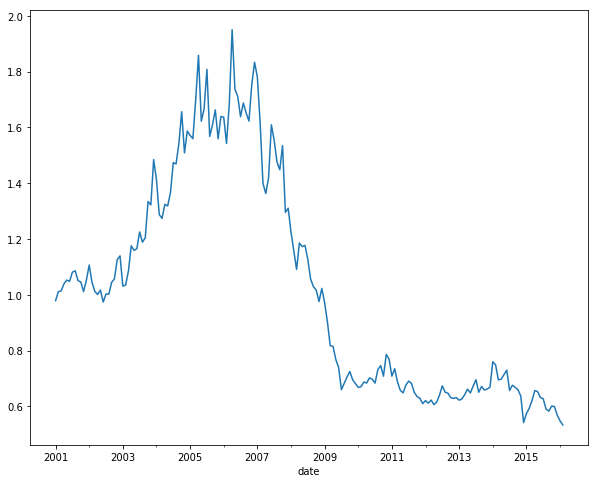

In [95]:
ewmomret2['mom_cum'] = ewmomret2[['long_short']].apply(lambda x: (1+x).cumprod()) 
ewmomret2.mom_cum.plot(figsize=(10, 8)) 
plt.show() 

In [98]:
from scipy import stats 

# Mean  
mom_mean = ewmomret2[['winners', 'losers', 'long_short']].mean().to_frame().reset_index() 
mom_mean.columns = ['momr', 'mean']

# T-Value and P-Value 
t_losers = pd.Series(stats.ttest_1samp(ewmomret2['losers'],0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewmomret2['winners'],0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewmomret2['long_short'],0.0)).to_frame().T

t_losers['momr']='losers' 
t_winners['momr']='winners' 
t_long_short['momr']='long_short' 

t_output =pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p 
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner') 
mom_output 

,momr,mean,t-stat,p-value
0,winners,0.012104,1.617389,0.107536
1,losers,0.014102,1.721458,0.086876
2,long_short,-0.001998,-0.500067,0.617635
